In [31]:
# Load necessary libraries
library(cansim)
library(dplyr)
library(tidyr)
library(lubridate)

# --- 1. DEFINE VECTORS ---

cpi_weight_vectors <- c(
  Food = "v91858740",
  Shelter = "v91858892",
  Household_operations = "v91858926",
  Clothing_footwear = "v91859016",
  Transportation = "v91859056",
  Health_personal_care = "v91859106",
  Recreation_education = "v91859144",
  Alcohol_tobacco = "v91859220"
)

cpi_vectors <- c(
  Food = "v41690973",
  Shelter = "v41691043",
  Household_operations = "v41691077",
  Clothing_footwear = "v41691167",
  Transportation = "v41691207",
  Health_personal_care = "v41691257",
  Recreation_education = "v41691295",
  Alcohol_tobacco = "v41691371"
)


# --- 2. DOWNLOAD AND PROCESS WEIGHTS ---

food_w_df <- get_cansim_vector(cpi_weight_vectors["Food"], start_time = "1996-01-01") %>% mutate(Component = "Food")
shelter_w_df <- get_cansim_vector(cpi_weight_vectors["Shelter"], start_time = "1996-01-01") %>% mutate(Component = "Shelter")
household_w_df <- get_cansim_vector(cpi_weight_vectors["Household_operations"], start_time = "1996-01-01") %>% mutate(Component = "Household_operations")
clothing_w_df <- get_cansim_vector(cpi_weight_vectors["Clothing_footwear"], start_time = "1996-01-01") %>% mutate(Component = "Clothing_footwear")
transport_w_df <- get_cansim_vector(cpi_weight_vectors["Transportation"], start_time = "1996-01-01") %>% mutate(Component = "Transportation")
health_w_df <- get_cansim_vector(cpi_weight_vectors["Health_personal_care"], start_time = "1996-01-01") %>% mutate(Component = "Health_personal_care")
recreation_w_df <- get_cansim_vector(cpi_weight_vectors["Recreation_education"], start_time = "1996-01-01") %>% mutate(Component = "Recreation_education")
alcohol_w_df <- get_cansim_vector(cpi_weight_vectors["Alcohol_tobacco"], start_time = "1996-01-01") %>% mutate(Component = "Alcohol_tobacco")

all_weights_df <- bind_rows(
  food_w_df, shelter_w_df, household_w_df, clothing_w_df, transport_w_df,
  health_w_df, recreation_w_df, alcohol_w_df
)

# [THE FIX] Create a complete MONTHLY dataframe of weights
monthly_weights_df <- all_weights_df %>%
  select(Date, Component, VALUE) %>%
  pivot_wider(names_from = Component, values_from = VALUE) %>%
  # Create a row for every month from the start date until today
  complete(Date = seq.Date(min(Date), today(), by = "month")) %>%
  # Fill downwards to propagate the last known weight into the new empty rows
  fill(everything(), .direction = "down") %>%
  # Apply your logic to lag the weights for basket alignment
  mutate(across(-Date, ~lag(.x))) %>%
  # Filter out any initial rows that are still NA before the data starts
  filter(!is.na(Food)) # Use a reliable column like Food as a reference


# --- 3. DOWNLOAD AND PROCESS CPI DATA ---

food_df <- get_cansim_vector(cpi_vectors["Food"], start_time = "2000-01-01") %>% mutate(Component = "Food")
# ... (rest of the CPI downloads are the same) ...
shelter_df <- get_cansim_vector(cpi_vectors["Shelter"], start_time = "2000-01-01") %>% mutate(Component = "Shelter")
household_df <- get_cansim_vector(cpi_vectors["Household_operations"], start_time = "2000-01-01") %>% mutate(Component = "Household_operations")
clothing_df <- get_cansim_vector(cpi_vectors["Clothing_footwear"], start_time = "2000-01-01") %>% mutate(Component = "Clothing_footwear")
transport_df <- get_cansim_vector(cpi_vectors["Transportation"], start_time = "2000-01-01") %>% mutate(Component = "Transportation")
health_df <- get_cansim_vector(cpi_vectors["Health_personal_care"], start_time = "2000-01-01") %>% mutate(Component = "Health_personal_care")
recreation_df <- get_cansim_vector(cpi_vectors["Recreation_education"], start_time = "2000-01-01") %>% mutate(Component = "Recreation_education")
alcohol_df <- get_cansim_vector(cpi_vectors["Alcohol_tobacco"], start_time = "2000-01-01") %>% mutate(Component = "Alcohol_tobacco")

all_cpi_df <- bind_rows(
  food_df, shelter_df, household_df, clothing_df, transport_df, health_df, recreation_df, alcohol_df
)

cpi_data_wide <- all_cpi_df %>%
  select(Date, Component, Value = VALUE) %>%
  pivot_wider(names_from = Component, values_from = Value) %>%
  arrange(Date)


# --- 4. JOIN DATA AND CALCULATE FINAL INDEX ---

groups <- list(
  Shelter = c("Shelter"),
  Food_transport_Components = c("Food", "Transportation"),
  Core_Goods = c("Household_operations", "Clothing_footwear", "Alcohol_tobacco"),
  Core_Services = c("Health_personal_care", "Recreation_education")
)

# [IMPROVEMENT] Join directly by the 'Date' column, which is cleaner and more accurate
data_with_weights <- cpi_data_wide %>%
  left_join(monthly_weights_df, by = "Date") %>%
  # The join may create NAs if CPI data goes beyond the weight data; remove them.
  filter(!is.na(Food.y)) 


calculate_group_index <- function(cpi_values, weights) {
  total_group_weight <- sum(weights, na.rm = TRUE)
  if (total_group_weight == 0) return(NA_real_)
  rescaled_weights <- weights / total_group_weight
  weighted_index <- sum(cpi_values * rescaled_weights, na.rm = TRUE)
  return(weighted_index)
}

final_weighted_cpi_levels <- data_with_weights %>%
  rowwise() %>%
  mutate(
    Shelter_Index = calculate_group_index(
      cpi_values = c_across(all_of(paste0(groups$Shelter, ".x"))),
      weights    = c_across(all_of(paste0(groups$Shelter, ".y")))
    ),
    Food_transport_Components_Index = calculate_group_index(
      cpi_values = c_across(all_of(paste0(groups$Food_transport_Components, ".x"))),
      weights    = c_across(all_of(paste0(groups$Food_transport_Components, ".y")))
    ),
    Core_Goods_Index = calculate_group_index(
      cpi_values = c_across(all_of(paste0(groups$Core_Goods, ".x"))),
      weights    = c_across(all_of(paste0(groups$Core_Goods, ".y")))
    ),
    Core_Services_Index = calculate_group_index(
      cpi_values = c_across(all_of(paste0(groups$Core_Services, ".x"))),
      weights    = c_across(all_of(paste0(groups$Core_Services, ".y")))
    )
  ) %>%
  ungroup() %>%
  select(Date, ends_with("_Index"))


# --- 5. VIEW FINAL RESULT ---
cat("Successfully calculated dynamically weighted CPI levels. Preview:\n")
glimpse(final_weighted_cpi_levels)

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Reading CANSIM NDM vectors from temporary cache

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in a

Successfully calculated dynamically weighted CPI levels. Preview:
Rows: 307
Columns: 5
$ Date                            <date> 2000-01-01, 2000-02-01, 2000-03-01, 2…
$ Shelter_Index                   <dbl> 97.5, 97.7, 96.8, 96.9, 96.9, 98.2, 96…
$ Food_transport_Components_Index <dbl> 93.70581, 94.15145, 94.74855, 94.60290…
$ Core_Goods_Index                <dbl> 96.19917, 96.23976, 94.52905, 96.02891…
$ Core_Services_Index             <dbl> 94.77098, 94.78391, 95.28076, 96.01956…


In [29]:
library(cansim)
library(dplyr)
library(ggplot2)

# Vector for "All-items" CPI (the official headline index level)
official_headline_cpi_vec <- "v41690973" 

official_cpi_df <- get_cansim_vector(official_headline_cpi_vec, start_time = "2000-01-01") %>%
  select(Date, Official_Headline_Index = VALUE)

cat("Successfully downloaded official headline CPI.\n")

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Reading CANSIM NDM vectors from temporary cache



Successfully downloaded official headline CPI.


Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Reading CANSIM NDM vectors from temporary cache



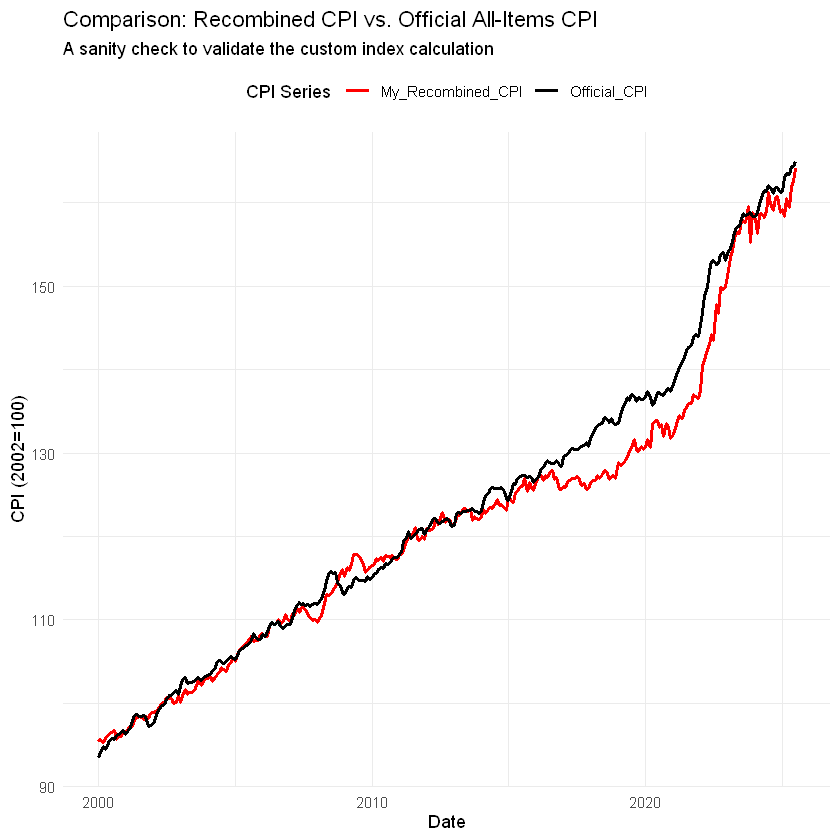

In [32]:
# --- 6. SANITY CHECK ---

# Ensure ggplot2 is loaded for plotting
library(ggplot2)

# --- 6.1. Calculate the weight of the 4 new categories ---

# Sum the weights of the components within each of your defined groups for each month
category_weights_df <- monthly_weights_df %>%
  # Note: monthly_weights_df already contains the correctly lagged weights
  mutate(
    Shelter_Weight = Shelter,
    Food_transport_Weight = Food + Transportation,
    Core_Goods_Weight = Household_operations + Clothing_footwear + Alcohol_tobacco,
    Core_Services_Weight = Health_personal_care + Recreation_education
  ) %>%
  select(Date, ends_with("_Weight"))


# --- 6.2. Recombine the components into a single index ---

# Join your calculated indices with their corresponding new category weights
recombined_cpi_df <- final_weighted_cpi_levels %>%
  left_join(category_weights_df, by = "Date") %>%
  # Calculate the total weight for each month (should sum to ~1000)
  mutate(Total_Weight = Shelter_Weight + Food_transport_Weight + Core_Goods_Weight + Core_Services_Weight) %>%
  # Calculate the final recombined index
  rowwise() %>%
  mutate(
    My_Recombined_CPI = sum(
      Shelter_Index * (Shelter_Weight / Total_Weight),
      Food_transport_Components_Index * (Food_transport_Weight / Total_Weight),
      Core_Goods_Index * (Core_Goods_Weight / Total_Weight),
      Core_Services_Index * (Core_Services_Weight / Total_Weight),
      na.rm = TRUE
    )
  ) %>%
  ungroup() %>%
  select(Date, My_Recombined_CPI)


# --- 6.3. Graph the result against the official Total CPI ---

# Vector for "All-items CPI, not seasonally adjusted"
total_cpi_official_vector <- "v41690973"

# Download the official data
official_cpi_df <- get_cansim_vector(total_cpi_official_vector, start_time = "2000-01-01") %>%
  select(Date, Official_CPI = VALUE)

# Join your recombined index with the official one
comparison_df <- recombined_cpi_df %>%
  left_join(official_cpi_df, by = "Date") %>%
  # Tidy the data for easy plotting with ggplot
  pivot_longer(
    cols = c("My_Recombined_CPI", "Official_CPI"),
    names_to = "Series",
    values_to = "Value"
  ) %>%
  filter(!is.na(Value)) # Remove any NA rows before plotting


# Create the plot
ggplot(comparison_df, aes(x = Date, y = Value, color = Series)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Comparison: Recombined CPI vs. Official All-Items CPI",
    subtitle = "A sanity check to validate the custom index calculation",
    x = "Date",
    y = "CPI (2002=100)",
    color = "CPI Series"
  ) +
  scale_color_manual(values = c("My_Recombined_CPI" = "red", "Official_CPI" = "black")) +
  theme_minimal() +
  theme(legend.position = "top")

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"


Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Reading CANSIM NDM vectors from temporary cache



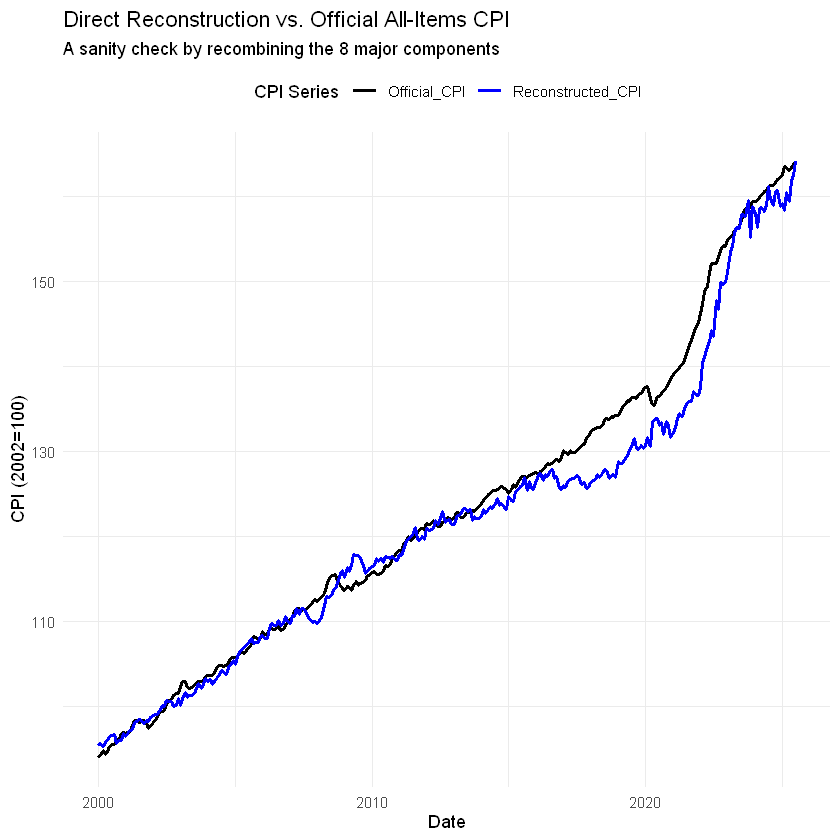

In [33]:
# --- 7. SECOND SANITY CHECK (Direct Reconstruction) ---

# Join the wide CPI data with the monthly lagged weights
# We add suffixes to distinguish the CPI value columns from the weight columns
direct_reconstruction_df <- cpi_data_wide %>%
  left_join(monthly_weights_df, by = "Date", suffix = c("_CPI", "_Weight")) %>%
  # Filter out any rows at the beginning or end that don't have matching data
  filter(!is.na(Food_Weight))

# Calculate the total weight and the reconstructed index for each month
direct_reconstruction_df <- direct_reconstruction_df %>%
  mutate(
    # Sum the weights of the 8 components to get the total basket weight for the month
    Total_Weight = Food_Weight + Shelter_Weight + Household_operations_Weight +
                   Clothing_footwear_Weight + Transportation_Weight + Health_personal_care_Weight +
                   Recreation_education_Weight + Alcohol_tobacco_Weight,
    
    # Calculate the weighted average of the 8 CPI components
    Reconstructed_CPI = (
      Food_CPI * Food_Weight +
      Shelter_CPI * Shelter_Weight +
      Household_operations_CPI * Household_operations_Weight +
      Clothing_footwear_CPI * Clothing_footwear_Weight +
      Transportation_CPI * Transportation_Weight +
      Health_personal_care_CPI * Health_personal_care_Weight +
      Recreation_education_CPI * Recreation_education_Weight +
      Alcohol_tobacco_CPI * Alcohol_tobacco_Weight
    ) / Total_Weight
  ) %>%
  select(Date, Reconstructed_CPI)


# --- 7.1. Graph the result against the official Total CPI ---

# Vector for "All-items CPI, not seasonally adjusted" remains the same
total_cpi_official_vector <- "v41690914"

# Download the official data
official_cpi_df <- get_cansim_vector(total_cpi_official_vector, start_time = "2000-01-01") %>%
  select(Date, Official_CPI = VALUE)

# Join your directly reconstructed index with the official one
comparison_df_2 <- direct_reconstruction_df %>%
  left_join(official_cpi_df, by = "Date") %>%
  # Tidy the data for easy plotting with ggplot
  pivot_longer(
    cols = c("Reconstructed_CPI", "Official_CPI"),
    names_to = "Series",
    values_to = "Value"
  ) %>%
  filter(!is.na(Value)) # Remove any NA rows


# Create the plot
ggplot(comparison_df_2, aes(x = Date, y = Value, color = Series)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Direct Reconstruction vs. Official All-Items CPI",
    subtitle = "A sanity check by recombining the 8 major components",
    x = "Date",
    y = "CPI (2002=100)",
    color = "CPI Series"
  ) +
  scale_color_manual(values = c("Reconstructed_CPI" = "blue", "Official_CPI" = "black")) +
  theme_minimal() +
  theme(legend.position = "top")

In [34]:
# --- 8. CALCULATE YEAR-OVER-YEAR (YOY) CHANGE ---

# Ensure dplyr is loaded
library(dplyr)

cpi_yoy_change <- final_weighted_cpi_levels %>%
  # Arrange by date to ensure correct lagging
  arrange(Date) %>%
  mutate(
    # Use across() to apply the same calculation to all columns ending with "_Index"
    across(
      .cols = ends_with("_Index"),
      # The formula for YoY % change
      .fns = ~ ((.x / lag(.x, 12)) - 1) * 100,
      # Rename the new columns to add a "_YoY" suffix
      .names = "{.col}_YoY"
    )
  ) %>%
  # The first 12 rows will have NA values, which is expected
  filter(!is.na(Shelter_Index_YoY))


# --- 9. VIEW FINAL RESULT ---
cat("Successfully calculated YoY CPI changes. Preview of the last few rows:\n")
tail(cpi_yoy_change)

Successfully calculated YoY CPI changes. Preview of the last few rows:


Date,Shelter_Index,Food_transport_Components_Index,Core_Goods_Index,Core_Services_Index,Shelter_Index_YoY,Food_transport_Components_Index_YoY,Core_Goods_Index_YoY,Core_Services_Index_YoY
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-02-01,154.1,154.9024,162.3087,168.6024,2.5282768,0.8797325,-0.0616015,1.768952
2025-03-01,161.7,157.8017,161.5221,163.0321,0.9363296,2.1690315,0.5584971,1.304981
2025-04-01,158.5,157.8516,162.1735,160.6663,-0.8135169,1.9372993,2.2184504,-2.903291
2025-05-01,164.4,158.5517,163.1185,162.9009,3.3962264,2.1912867,1.7356050,1.369335
2025-06-01,163.4,158.6017,164.7612,166.2678,1.2391574,2.1906195,2.3078406,3.984057
2025-07-01,168.3,158.9018,165.4264,165.7370,0.4776119,2.2520903,2.3105798,2.623518


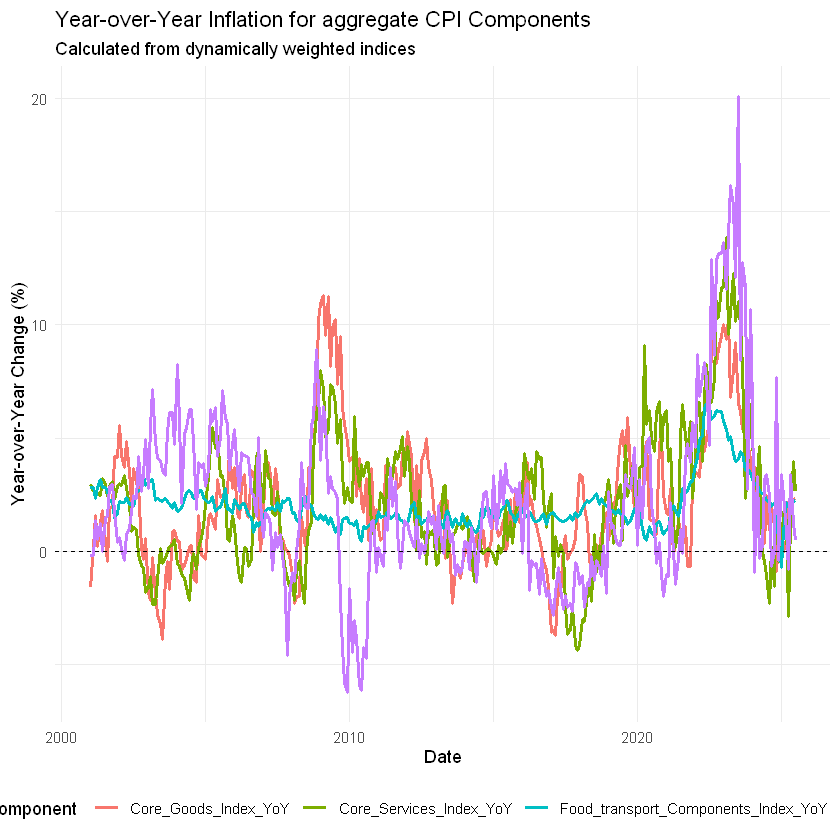

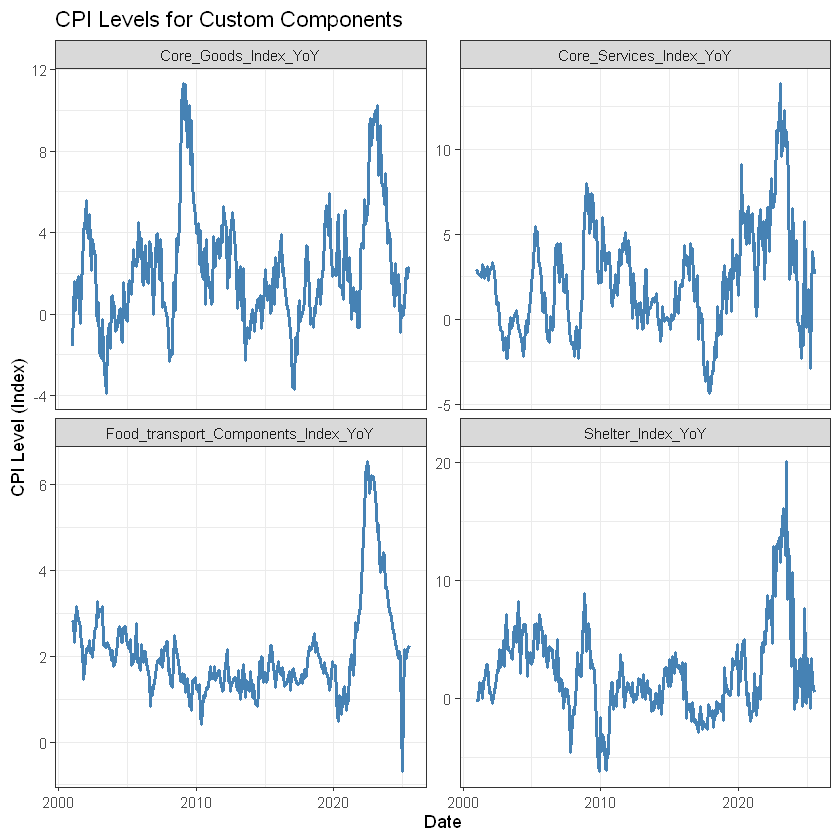

In [35]:
# --- 10. PLOT YOY CHANGES ---
library(ggplot2)
library(tidyr) # For pivot_longer

# Tidy the data for easy plotting
cpi_yoy_plot_data <- cpi_yoy_change %>%
  select(Date, ends_with("_YoY")) %>%
  pivot_longer(
    cols = -Date,
    names_to = "Component",
    values_to = "YoY_Change"
  )

# Create the plot
ggplot(cpi_yoy_plot_data, aes(x = Date, y = YoY_Change, color = Component)) +
  geom_line(linewidth = 1) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") + # Add a zero line
  labs(
    title = "Year-over-Year Inflation for aggregate CPI Components",
    subtitle = "Calculated from dynamically weighted indices",
    x = "Date",
    y = "Year-over-Year Change (%)",
    color = "Custom CPI Component"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

ggplot(cpi_yoy_plot_data, aes(x = Date, y = YoY_Change)) +
  geom_line(color = "steelblue", linewidth = 1) +
  # This is the key function to create separate graphs for each component
  facet_wrap(~ Component, scales = "free_y") +
  labs(
    title = "CPI Levels for Custom Components",
    x = "Date",
    y = "CPI Level (Index)"
  ) +
  theme_bw() 

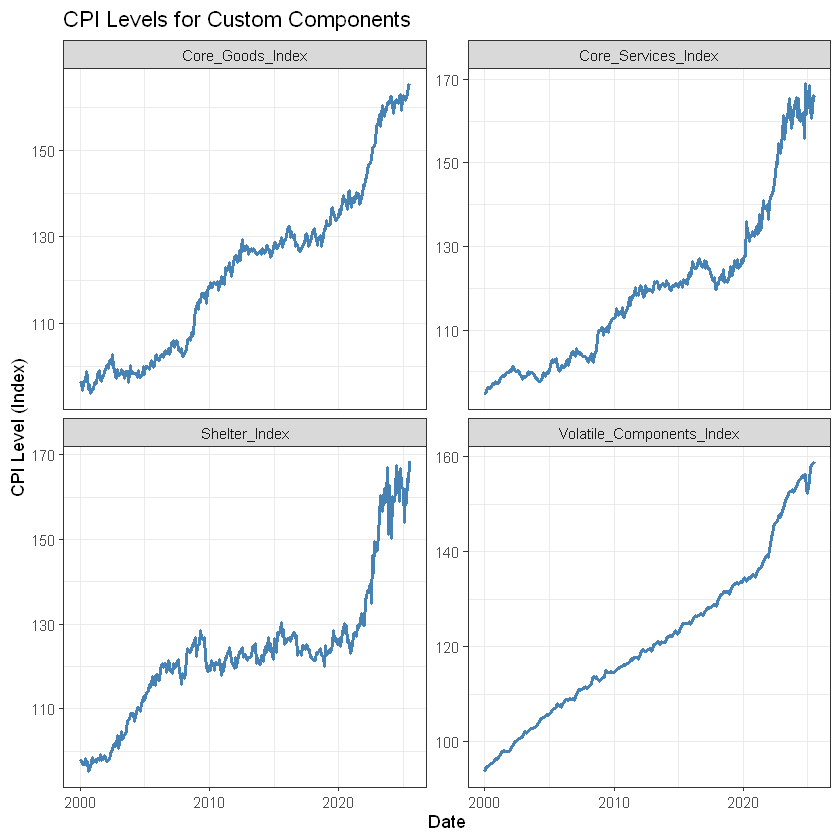

In [ ]:
# Ensure ggplot2 and tidyr are loaded
library(ggplot2)
library(tidyr)

# Reshape the data from wide to long format for faceting
cpi_levels_plot_data <- final_weighted_cpi_levels %>%
  pivot_longer(
    cols = -Date,
    names_to = "Component",
    values_to = "Index_Level"
  )

# Create the faceted plot
ggplot(cpi_levels_plot_data, aes(x = Date, y = Index_Level)) +
  geom_line(color = "steelblue", linewidth = 1) +
  # This is the key function to create separate graphs for each component
  facet_wrap(~ Component, scales = "free_y") +
  labs(
    title = "CPI Levels for Custom Components",
    x = "Date",
    y = "CPI Level (Index)"
  ) +
  theme_bw() # A clean theme for faceted plots

In [37]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)
library(purrr) 
library(vars)
library(fredr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.1.0     ✔ tibble  3.3.0
✔ readr   2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'vroom'


The following objects are masked from 'package:readr':

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo

In [38]:
fredr_set_key('b43b23bac4c602369428a1a4316f23d4')

In [39]:
all_tarrif_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-Export.csv")

general_import_charges <- all_tarrif_data|>
filter(`Data Type` == "General Import Charges")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()

general_customs_value <- all_tarrif_data|>
filter(`Data Type` == "General Customs Value")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()



tarrif_rate_df <- inner_join(
  general_import_charges, 
  general_customs_value, 
  by = "Date",
  suffix = c("_charges", "_value")
) |>
  
  # 2. Calculate the approximate tariff rate using the two VALUE columns
  mutate(
    Approximate_Rate = (VALUE_charges / VALUE_value) * 100
  ) |>
  rename(month = Date)|>
  # 3. Keep only the columns you need for your VAR model
  dplyr::select(month, Approximate_Rate)

# --- Check the final result ---
glimpse(tarrif_rate_df)

Rows: 616 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Data Type, Year, Month, General Customs Value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 269869762, 278547963, 305301730, 290530227, 301763964, 297764412…
Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 17705142820, 18087403941, 20618285791, 18506995213, 19558432594,…
Rows: 306
Columns: 2
$ month            <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000…
$ Approximate_Rate <dbl> 1.524245, 1.540011, 1.480733, 1.569840, 1.542884, 1.4…


In [43]:

### EXCHANGE RATE US-CANADA ###
exc_rate <- fredr(
  series_id = "DEXCAUS",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)

### TRADE COMMODITIES US-CANADA ###
trade_commodities <- fredr(
  series_id = "XTNTVA01CAM664S",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)


### TRADE POLICY UNCERTAINTY INDEX ###
tpu_data <- read_csv("Categorical_EPU_Data.csv")|>
mutate(Date = ymd(paste(Year, Month, "01", sep = "-")))|>
rename(VALUE = '9. Trade policy')|>
glimpse()


### lFS MICRO ###
lfs_micro <- read_csv('C:/Users/Irene/governorschallenge/INDINF_WAGES_MONTHLY.csv', skip=20)|>
dplyr::select(date, INDINF_LFSMICRO_M)|>
rename(Date = date, VALUE = INDINF_LFSMICRO_M)|>
  mutate(Date = mdy(Date)) |>
  filter(Date > ymd("2000-12-31"))|>
glimpse()


unemp_vec <- get_cansim_vector_for_latest_periods('v2062815', periods = 500, refresh = TRUE) # UNEMPLOYMENT RATE
fcpi_vec <- get_cansim_vector_for_latest_periods('v52673496', periods = 500, refresh = TRUE) ## FISHER COMMODITY PRICE INDEX
wti_price_monthly <- fredr::fredr(series_id = "MCOILWTICO") ## CRUDE OUL PRICES -- WEST TEXAS INTERMEDIATE
gdp_vec <- get_cansim_vector_for_latest_periods("v65201210", periods = 300, refresh = TRUE) # GDP

Rows: 488 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Year
dbl (2): Month, 9. Trade policy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = ymd(paste(Year, Month, "01", sep = "-"))`.
Caused by warning:
!  1 failed to parse."


Rows: 488
Columns: 4
$ Year  <chr> "1985", "1985", "1985", "1985", "1985", "1985", "1985", "1985", …
$ Month <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9…
$ VALUE <dbl> 122.61396, 41.76222, 107.92573, 194.75287, 124.39166, 153.16361,…
$ Date  <date> 1985-01-01, 1985-02-01, 1985-03-01, 1985-04-01, 1985-05-01, 198…


Rows: 390 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): date
dbl (7): INDINF_LFSMICRO_M, INDINF_LFSMICRO_LEVELS_M, INDINF_LFSWC_M, INDINF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 294
Columns: 2
$ Date  <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-01, 200…
$ VALUE <dbl> 2.8, 3.3, 3.4, 3.3, 3.6, 3.3, 3.3, 3.1, 3.0, 3.0, 3.2, 3.4, 3.2,…


Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada



In [41]:
## BREAK EVEN INFLATION RATE

monthly_real_return_bond <- get_cansim_vector_for_latest_periods('v122553',periods = 500)
monthly_convetional_bond <- get_cansim_vector_for_latest_periods('v122543',periods = 500)
monthly_real_return_bond <- monthly_real_return_bond|>
dplyr::select(Date, VALUE)

monthly_convetional_bond <- monthly_convetional_bond|>
dplyr::select(Date, VALUE)

break_even_df <- monthly_convetional_bond |>
  inner_join(monthly_real_return_bond, by = "Date", suffix = c("_conventional", "_real_return")) |>
  mutate(break_even_inflation_rate = VALUE_conventional - VALUE_real_return) |>
  dplyr::select(Date, break_even_inflation_rate)


Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada



In [42]:
supply_chain_pressure <- read_csv("C:/Users/Irene/governorschallenge/gscpi_data.csv")|>
dplyr::select(Date, GSCPI)|>
glimpse()


home_price_index <- read_csv("C:/Users/Irene/governorschallenge/House_Price_Index.csv")|>
dplyr::select(Date, Smoothed_Index)|>
glimpse()


New names:
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
Rows: 331 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Date
dbl  (1): GSCPI
lgl (12): ...3, ...4, ...5, ...6, ...7, ...8, ...9, ...10, ...11, ...12, ......

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 331
Columns: 2
$ Date  <chr> "31-Jan-1998", "28-Feb-1998", "31-Mar-1998", "30-Apr-1998", "31-…
$ GSCPI <dbl> -1.08, -0.46, -0.07, -0.12, -0.44, -0.74, -0.89, -0.85, -0.89, -…


New names:
• `Index` -> `Index...2`
• `SA Index` -> `SA Index...3`
• `Smoothed SA Index` -> `Smoothed SA Index...5`
• `Sales Pair Count` -> `Sales Pair Count...6`
• `Index` -> `Index...7`
• `SA Index` -> `SA Index...8`
• `Smoothed Index` -> `Smoothed Index...9`
• `Smoothed SA Index` -> `Smoothed SA Index...10`
• `Sales Pair Count` -> `Sales Pair Count...11`
• `Index` -> `Index...12`
• `SA Index` -> `SA Index...13`
• `Smoothed Index` -> `Smoothed Index...14`
• `Smoothed SA Index` -> `Smoothed SA Index...15`
• `Sales Pair Count` -> `Sales Pair Count...16`
• `Index` -> `Index...17`
• `SA Index` -> `SA Index...18`
• `Smoothed Index` -> `Smoothed Index...19`
• `Smoothed SA Index` -> `Smoothed SA Index...20`
• `Sales Pair Count` -> `Sales Pair Count...21`
• `Index` -> `Index...22`
• `SA Index` -> `SA Index...23`
• `Smoothed Index` -> `Smoothed Index...24`
• `Smoothed SA Index` -> `Smoothed SA Index...25`
• `Sales Pair Count` -> `Sales Pair Count...26`
• `Index` -> `Index...27`
• `SA Index` -

Rows: 422
Columns: 2
$ Date           <chr> "Jun-90", "Jul-90", "Aug-90", "Sep-90", "Oct-90", "Nov-…
$ Smoothed_Index <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…


In [ ]:
gdp_monthly <- gdp_vec |>
  dplyr::select(Date, VALUE) |>
  # Create a 'month' column and filter
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Calculate month-over-month percent change
  dplyr::mutate(
    delta_gdp = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_gdp) |>
  tidyr::drop_na()

# --- Break-even Inflation Rate ---
bond_monthly <- break_even_df |>
  dplyr::select(Date, break_even_inflation_rate) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_bond = (log(break_even_inflation_rate) - log(dplyr::lag(break_even_inflation_rate, 1))) * 100
  ) |>
  dplyr::select(month, delta_bond) |>
  tidyr::drop_na()

# ppc_monthly <- ppc_data |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
#   dplyr::filter(month >= start_date) |>
#   dplyr::mutate(
#     delta_ppc = VALUE
#   ) |>
#   dplyr::select(month, delta_ppc) |>
#   tidyr::drop_na()

# --- Oil ---
oil_monthly <- wti_price_monthly |>
  dplyr::select(date, value) |>
  dplyr::mutate(month = date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_oil = (log(value) - log(dplyr::lag(value, 1))) * 100
  ) |>
  dplyr::select(month, delta_oil) |>
  tidyr::drop_na()

trade_unc_monthly <- tpu_data |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_trade_unc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_trade_unc) |>
  tidyr::drop_na()

# --- No changes needed for your inflation calculation ---
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(
    delta_inflation =  VALUE
  ) |>
  dplyr::select(month, delta_inflation) |>
  tidyr::drop_na()

fcpi_monthly <- fcpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(
    delta_fcpi = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_fcpi) |>
  tidyr::drop_na()|>
  glimpse()

# --- ULC (if you decide to use it, assuming it's monthly) ---
# ulc_monthly <- ulc_vec |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
#   dplyr::filter(month >= start_date) |>
#   dplyr::mutate(
#     delta_ulc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
#   ) |>
#   dplyr::select(month, delta_ulc) |>
#   tidyr::drop_na()

# Process CPI (monthly percent change)
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::mutate(
    delta_cpi = VALUE) |>
  dplyr::select(month, delta_cpi) |>
  tidyr::drop_na()

trade_commodities_monthly <- trade_commodities |>
  dplyr::select(date, value) |>
  dplyr::mutate(month = date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    trade_us_canada = value) |>
  dplyr::select(month, trade_us_canada ) |>
  tidyr::drop_na()

lfs_micro_monthly <- lfs_micro |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    lfs_micro = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100) |>
  dplyr::select(month, lfs_micro) |>
  tidyr::drop_na()

# Process Exchange Rate (quarterly percent change)
# exc_quarterly <- exc_vec |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(quarter = lubridate::floor_date(Date, "quarter")) |>
#   dplyr::group_by(quarter) |>
#   dplyr::summarise(VALUE = dplyr::last(VALUE), .groups = 'drop') |>
#   dplyr::filter(quarter >= start_date) |> #
#   dplyr::mutate(
#     delta_exc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
#   ) |>
#   dplyr::select(quarter, delta_exc) |>
#   tidyr::drop_na()

# Process Unemployment (using the rate level)
unemp_monthly <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Using the unemployment rate level directly
  dplyr::mutate(
    delta_unemp = VALUE
  ) |>
  dplyr::select(month, delta_unemp) |>
  tidyr::drop_na()


exc_monthly <- exc_rate |>
rename(month = date)|>
rename(delta_exc = value)|>
dplyr::select(month, delta_exc)|>
tidyr::drop_na()